In [67]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score,classification_report,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost
from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN,SVMSMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


In [68]:
#ingore warnings
warnings.filterwarnings("ignore")
xgboost.set_config(verbosity=0)
#to show more rows and columns in pandas Dataframe
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
#set inf in pandas Dataframe to missing values
pd.options.mode.use_inf_as_na = True

# Loading data files

## We use 

In [69]:

dataset_close_state=pd.read_csv('data\hospital_closure\hospital_closure.csv')
dataset=pd.read_csv('data\hospital_closure\hosp_closest_info_v5.csv',thousands=',')

In [70]:
def check(a, b):
    if  a == b-1 or a == b-2:
        return 1
    else:
        return 0

In [71]:
dataset.drop(dataset[dataset['year']==2017].index,inplace=True)
#dataset['year_close_combined'].fillna(0,inplace=True)
#dataset['Closure']=dataset.apply(lambda x:check(float(x['year']),x['year_close_combined']),axis=1)
dataset['Closure']=dataset.apply(lambda x:1 if int(x['provider']) in np.array(dataset_close_state['id']) and check(float(x['year']),int(dataset_close_state[dataset_close_state['id']==int(x['provider'])]['year_close_combined'])) else 0,axis=1)

In [72]:
dataset['provider']=pd.to_numeric(dataset['provider']).astype(int)
dataset.loc[dataset['provider']==200025,'Closure']=0
dataset.loc[dataset['provider']==260147,'Closure']=0
dataset.loc[dataset['provider']==440047,'Closure']=0
dataset.loc[dataset['provider']==180149,'Closure']=0
dataset.loc[dataset['provider']==450832,'Closure']=0
dataset.loc[dataset['provider']==670052,'Closure']=0
dataset.loc[dataset['provider']==330225,'Closure']=0
dataset.loc[dataset['provider']==360347,'Closure']=0
dataset.loc[dataset['provider']==390108,'Closure']=0
dataset.loc[dataset['provider']==150170,'Closure']=0
dataset.loc[dataset['provider']==40142,'Closure']=0
dataset.loc[dataset['provider']==390131,'Closure']=0
dataset.loc[dataset['provider']==390010,'Closure']=0
dataset.loc[dataset['provider']==330036,'Closure']=0

In [73]:
dataset['c']=dataset.apply(lambda x:1 if int(x['provider']) in np.array(dataset_close_state['id']) and x['Closure']==0 else 0,axis=1)
dataset.drop(dataset[dataset['c']==1].index,inplace=True)
dataset.drop(columns=['c'],inplace=True)

In [10]:
dataset_save=dataset[['provider','year','dshpct','gme_part_a','gme_part_b','beds','bed_days','medicare_days','medicaid_days','days','employees','medicare_disch','medicaid_disch','discharges','doc_communicate','nurse_communicate','help_quick','staff_explain','pain_control','area_quiet','room_clean','discharge_info','recommend','survey_response_rate','race.x','race.y','buyin_mo','type_adm.x','type_adm.y','type_adm','ind_dsh','ind_teaching','efficiency','utilization','hsanum','prop_discharges','rate.y','rural_urban','pop','unemp','poverty','under_65','prop_phy_pcp','prop_md_pcp','prop_pcp','prop_gi','prop_gen_int','prop_hosp','prop_hosp_short','prop_cah','prop_hosp_adm','prop_hosp_adm_short','prop_hosp_bed','prop_hosp_bed_short','prop_days_inp','prop_days_inp_short','prop_days_inp_med']]
dataset_save.replace({'Not Available':np.nan,' Not Available':np.nan},inplace=True)
dataset_save.replace({np.inf:np.nan},inplace=True)
dataset_save.drop_duplicates(inplace=True)
dataset_save.to_csv('cha.csv')

C:\Users\zys\Anaconda3\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-10-e8f9054169fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_save.drop_duplicates(inplace=True)


In [337]:
dataset['pop'].value_counts(dropna=0).sort_index()

0.0            49
775.0           2
1152.0         16
1159.0         16
1251.0         12
             ... 
3880244.0     678
4180894.0     953
5217080.0    1021
9889056.0    3194
NaN          5554
Name: pop, Length: 2478, dtype: int64

In [554]:
dataset_=dataset[['provider','dshpct','ime1','ime2','ime3','dsh1','dsh2','dsh3','gme_part_a','gme_part_b','beds','bed_days','medicare_days','medicaid_days','days','employees','medicare_disch','medicaid_disch','discharges','overall','doc_communicate','nurse_communicate','help_quick','staff_explain','pain_control','area_quiet','room_clean','discharge_info','recommend','survey_response_rate','race.x','race.y','buyin_mo','type_adm.x','type_adm.y','type_adm','ind_dsh','ind_teaching','efficiency','utilization','hsanum','prop_discharges','rate.y','rural_urban','pop','unemp','poverty','under_65','prop_phy_pcp','prop_md_pcp','prop_pcp','prop_gi','prop_gen_int','prop_hosp','prop_hosp_short','prop_cah','prop_hosp_adm','prop_hosp_adm_short','prop_hosp_bed','prop_hosp_bed_short','prop_days_inp','prop_days_inp_short','prop_days_inp_med','mortality','safety','readmin','patient_exp','effective','timely','Closure']]
#,'dshpct','gme_part_a','gme_part_b','beds','bed_days__','medicare_days','medicaid_days__','days','employees__','medicare_disch','medicaid_disch','discharges','doc_communicate','nurse_communicate','help_quick_','staff_explain','pain_control_','area_quiet','room_clean_','discharge_info','recommend','survey_response_rate__','race.x','race.y','buyin_mo_','type_adm.x','type_adm.y','type_adm','ind_dsh__','ind_teaching','efficiency','utilization','hsanum','prop_discharges','rate.y','rural_urban','unemp','poverty','under_65','prop_phy_pcp','prop_md_pcp','prop_pcp__','prop_gi__','prop_gen_int','prop_hosp','prop_hosp_short','prop_cah','prop_hosp_adm__','prop_hosp_adm_short__','prop_hosp_bed','prop_hosp_bed_short','prop_days_inp__','prop_days_inp_short__','prop_days_inp_med__'

In [81]:
dataset_=dataset[['provider','dshpct','ime1','dsh1','gme_part_a','gme_part_b','beds','bed_days','medicare_days','medicaid_days','days','employees','medicare_disch','medicaid_disch','discharges','ind_dsh','ind_teaching','efficiency','utilization',
                'overall','doc_communicate','nurse_communicate','help_quick','staff_explain','pain_control','area_quiet','room_clean','discharge_info','recommend','survey_response_rate',
                'mortality','safety','readmin','patient_exp','effective','timely',
               
                'hsanum','prop_discharges','rural_urban','pop','unemp','poverty','under_65',
                'prop_phy_pcp','prop_md_pcp','prop_pcp','prop_gi','prop_gen_int','prop_hosp','prop_hosp_short','prop_cah','prop_hosp_adm','prop_hosp_adm_short','prop_hosp_bed','prop_hosp_bed_short','prop_days_inp','prop_days_inp_short','prop_days_inp_med','Closure']]

In [78]:
dataset_.describe()

,provider,dshpct,ime1,dsh1,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,ind_dsh,ind_teaching,efficiency,utilization,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,survey_response_rate,mortality,safety,readmin,patient_exp,effective,timely,hsanum,prop_discharges,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,Closure
count,93805.000000,17533.000000,6.839000e+03,4.372500e+04,1.793000e+04,1.858200e+04,93792.000000,9.380300e+04,93326.000000,33721.000000,93805.000000,9.339700e+04,93340.000000,84782.000000,93805.000000,93805.000000,93805.000000,93805.000000,93805.000000,32232.000000,32232.000000,32233.000000,32228.000000,32194.000000,32212.000000,32233.000000,32232.000000,32225.000000,32232.000000,32154.000000,53110.000000,41949.000000,58858.000000,52977.000000,56671.000000,55707.000000,91805.000000,91805.000000,88272.000000,8.827200e+04,88272.000000,88272.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,88223.000000,93805.000000
mean,266198.971878,0.157828,6.569822e+06,2.946900e+06,2.013480e+06,6.104451e+05,131.359284,5.903081e+04,11162.311457,4194.015925,30350.253345,8.399460e+02,1922.764142,884.739732,5730.852908,0.467097,0.195309,34.701827,0.517557,68.732843,80.894142,77.343778,65.680216,62.246847,69.916863,59.425589,72.067045,83.814988,70.117399,32.159607,2.012383,2.064523,2.005488,2.010615,1.962709,2.033580,26413.033016,1545.030678,3.859706,6.763248e+05,8.673827,16.182241,82.539139,0.000715,0.000637,0.002832,0.000035,0.000300,0.000048,0.000040,0.000027,0.127570,0.118217,0.004126,0.003441,0.947561,0.752696,0.299218,0.002910
std,153383.933644,0.125395,1.162137e+07,4.890658e+06,3.586949e+06,1.172906e+06,156.365119,3.585380e+06,15261.937775,9054.315976,43872.061293,1.236325e+04,2702.093279,1692.781764,8479.209328,0.498919,0.396441,20.584733,0.231350,9.464644,5.517204,6.341803,9.463061,7.255385,5.928070,10.518129,8.097437,5.344445,10.065471,9.345813,0.444872,0.647941,0.660569,0.782722,0.274142,0.729168,15007.347773,1248.065328,7.162157,1.534059e+06,2.610700,5.545893,7.084615,0.000333,0.000317,0.002574,0.000042,0.000297,0.000072,0.000068,0.000074,0.088051,0.081657,0.003976,0.003241,1.122993,0.822313,0.248953,0.053869
min,10001.000000,0.001000,1.360000e+02,5.600000e+01,-1.744730e+05,-3.667300e+04,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e-02,1.000000,1.000000,1.000000,0.000000,0.000000,0.006303,0.000040,10.000000,14.000000,8.000000,11.000000,1.000000,0.000000,0.000000,6.000000,27.000000,6.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1001.000000,163.905971,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,140206.000000,0.082400,5.771500e+05,3.287460e+05,1.612345e+05,3.442200e+04,25.000000,9.150000e+03,1851.250000,170.000000,4133.000000,1.228200e+02,253.000000,43.000000,550.000000,0.000000,0.000000,16.733330,0.337378,63.000000,77.000000,74.000000,60.000000,58.000000,67.000000,52.000000,67.000000,81.000000,64.000000,26.000000,2.000000,1.666667,1.666667,1.000000,2.000000,1.333333,14063.000000,601.306700,1.000000,3.333500e+04,7.000000,12.300000,80.735670,0.000499,0.000426,0.001119,0.000000,0.000107,0.000015,0.000010,0.000000,0.071797,0.068634,0.002142,0.001823,0.381396,0.334610,0.156704,0.000000
50%,252003.000000,0.120000,2.149181e+06,1.098594e+06,6.892795e+05,1.824830e+05,72.000000,2.555000e+04,5234.000000,949.000000,13043.000000,2.992000e+02,747.000000,2

In [114]:
sns.pairplot(dataset_)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001A69DF42700> (for post_execute):


KeyboardInterrupt: 

[]

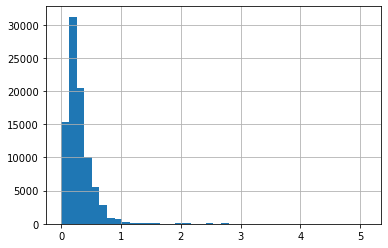

In [113]:
dataset_['prop_days_inp_med'].hist(bins=40).plot()

In [87]:
dataset_['ime1'].value_counts(dropna=0)

NaN          86966
12172.0          2
72525.0          2
2357928.0        2
203330.0         2
             ...  
2430608.0        1
3479232.0        1
1215355.0        1
2430822.0        1
9371693.0        1
Name: ime1, Length: 6832, dtype: int64

In [242]:
dataset_

,provider,dshpct,ime1,ime2,ime3,dsh1,dsh2,dsh3,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,survey_response_rate,ind_dsh,ind_teaching,efficiency,utilization,hsanum,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,mortality,safety,readmin,patient_exp,effective,timely,Closure
0,10073,NaN,NaN,NaN,NaN,NaN,80350.0,NaN,NaN,NaN,46.0,16790.0,5409.0,NaN,7948,205.000000,1082.0,232.0,2100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,45.652174,0.473377,1006.0,416.729914,NaN,9.0,13862.0,11.8,20.6,81.791949,0.000361,0.000361,0.000721,0.000000,0.000072,0.000072,0.000072,0.0,0.090463,0.090463,0.009306,0.009306,2.373539,2.373539,0.366542,2.000000,NaN,2.333333,2.000000,1.333333,2.000000,0
1,10046,NaN,NaN,NaN,NaN,3588783.0,NaN,NaN,NaN,NaN,281.0,102565.0,36053.0,NaN,54864,833.900024,5738.0,1394.0,10424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,37.096085,0.534919,1039.0,416.729914,NaN,3.0,104303.0,9.1,19.0,82.708072,0.000719,0.000671,0.002196,0.000048,0.000192,0.000038,0.000019,0.0,0.216120,0.191644,0.005657,0.004631,1.311707,1.027736,0.647872,2.000000,3.0,2.000000,1.000000,1.666667,2.333333,0
2,10011,NaN,NaN,1456787.0,NaN,892617.0,NaN,NaN,898821.0,136038.0,237.0,90155.0,26904.0,NaN,59743,843.000000,5363.0,903.0,13849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,58.434599,0.690631,1011.0,416.729914,NaN,1.0,658931.0,8.7,18.6,84.804479,0.000982,0.000952,0.006362,0.000091,0.000756,0.000023,0.000014,0.0,0.264985,0.232287,0.006441,0.005428,1.582758,1.302935,0.586647,2.000000,1.0,2.333333,1.000000,1.333333,2.000000,0
3,10104,NaN,NaN,3008272.0,NaN,1761034.0,NaN,NaN,2051016.0,155872.0,341.0,124465.0,41015.0,NaN,78224,1392.290039,7979.0,1105.0,16925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,49.633431,0.628482,1011.0,416.729914,NaN,1.0,658931.0,8.7,18.6,84.804479,0.000982,0.000952,0.006362,0.000091,0.000756,0.000023,0.000014,0.0,0.264985,0.232287,0.006441,0.005428,1.582758,1.302935,0.586647,1.333333,1.0,1.666667,2.666667,2.000000,3.000000,0
4,10103,NaN,NaN,3166092.0,NaN,2880694.0,NaN,NaN,1967241.0,235667.0,303.0,114975.0,38490.0,NaN,74700,1181.359985,6025.0,1285.0,13576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,44.805281,0.675437,1011.0,416.729914,NaN,1.0,658931.0,8.7,18.6,84.804479,0.000982,0.000952,0.006362,0.000091,0.000756,0.000023,0.000014,0.0,0.264985,0.232287,0.006441,0.005428,1.582758,1.302935,0.586647,1.000000,3.0,1.666667,2.666667,2.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103031,400001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.0,64605.0,4096.0,NaN,40149,726.650000,570.0,NaN,8819,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,49.824860,0.621453,NaN,NaN,NaN,99.0,389714.0,11.5,0.0,0.000000,0.001996,0.001996,0.009941,0.000136,0.000875,0.000054,0.000036,0.0,0.360503,0.307513,0.009504,0.007772,2.770332,2.261728,0.904130,2.000000,2.0,1.666667,NaN,NaN,NaN,0
103032,400012,0.3500,NaN,NaN,NaN,44605.0,NaN,NaN,NaN,NaN,62.0,22630.0,318.0,1177.0,6318,220.080000,95.0,543.0,1256,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,1,0,20.258060,0.279187,NaN,NaN,NaN,99.0,389714.0,11.5,0.0,0.000000,0.001996,0.001996,0.009941,0.000136,0.000875,0.000054,0.000036,0.0,0.360503,0.307513,0.00

In [248]:
dataset_['rural_urban'].value_counts(dropna=0)

1.0     31659
2.0     15256
6.0     10583
3.0     10327
7.0      7928
4.0      5602
NaN      5554
9.0      3944
5.0      2728
8.0      2097
99.0      437
Name: rural_urban, dtype: int64

In [82]:
dataset_.replace({'Not Available':np.nan,' Not Available':np.nan},inplace=True)
#dataset_['pop'].replace({0:np.nan},inplace=True)
#dataset_['poverty'].replace({0:np.nan},inplace=True)
#dataset_['under_65'].replace({0:np.nan},inplace=True)
dataset_.replace({np.inf:np.nan},inplace=True)
#dataset_['num_complete_survey']=dataset_['num_complete_survey'].replace({'300 or more':1664.66,'300 or More':1664.66,'Between 100 and 299':200,'Not Available':np.nan,'Fewer than 100':66,'FEWER THAN 50':40})

In [115]:
dataset_.drop_duplicates(inplace=True)

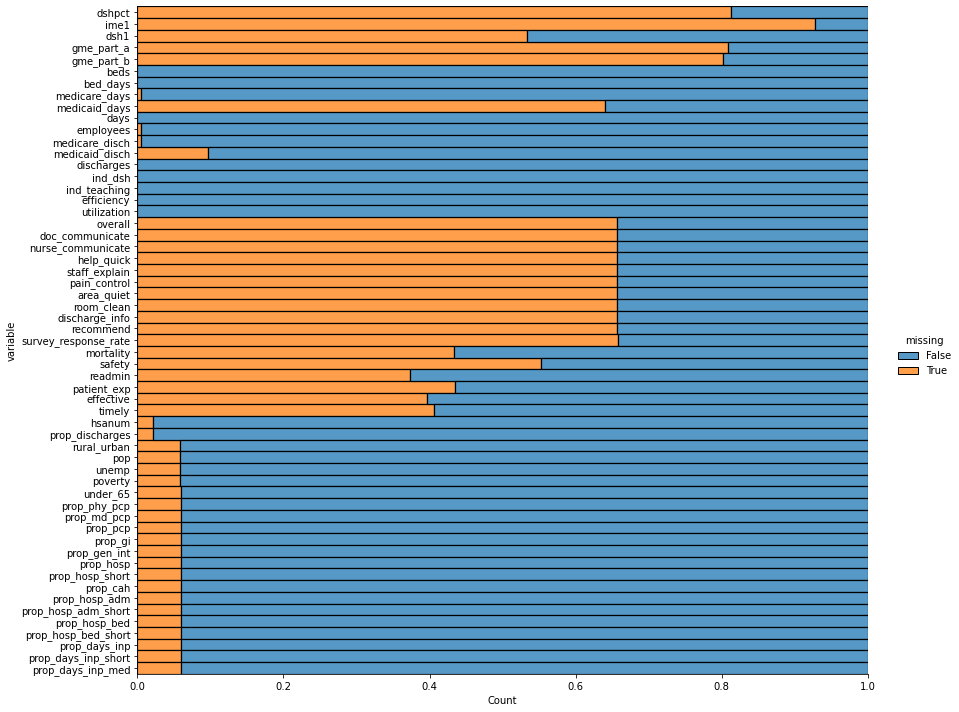

In [13]:
sns.displot(
    data=dataset_.copy().drop(columns=['provider','Closure']).isna().melt(value_name="missing"),
    
    y="variable",
    hue="missing",
    multiple="fill",
    height=10,
    aspect=1.25
)

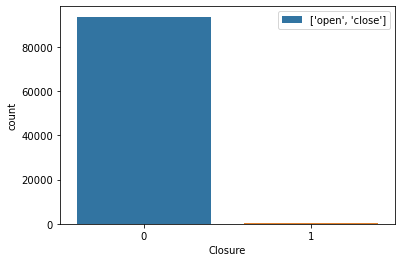

In [14]:
sns.countplot(x ='Closure',data=dataset_, label=['open','close'])
plt.legend()


In [116]:
dataset_['rural_urban'].fillna(dataset_['rural_urban'].value_counts().index[0],inplace=True)
dataset_.fillna(dataset_.median(),inplace=True)
#dataset_.drop(columns=['provider'],inplace=True)

In [59]:
Y=dataset_['Closure']
dataset_.drop(columns=['provider','Closure'],inplace=True)

C:\Users\zys\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [122]:
poly = PolynomialFeatures(2)
dataset_=poly.fit_transform(dataset_)

In [124]:
dataset_.shape

In [117]:
scaler = StandardScaler()
dataset_ = scaler.fit_transform(dataset_)

In [46]:
scaler = RobustScaler()
dataset_ = scaler.fit_transform(dataset_)

In [98]:
#dataset_.drop(columns='provider',inplace=True)
imputer = KNNImputer(n_neighbors=1)
dataset_=imputer.fit_transform(dataset_.to_numpy())

In [60]:
imputer_i=IterativeImputer(max_iter=50)
imputer_i.fit(dataset_)
dataset_=imputer_i.transform(dataset_)

C:\Users\zys\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [87]:
pca = PCA(n_components=20)
dataset_ = pca.fit_transform(dataset_)

In [281]:
a = dataset_['num_complete_survey'].map(lambda x: x if isinstance(x, float) else np.nan)
#a=dataset_['num_complete_survey'].where(a)

In [282]:
a.value_counts(dropna=0)

NaN    97698
Name: num_complete_survey, dtype: int64

In [274]:
a = dataset_['num_complete_survey'].map(lambda x:type(x))

In [275]:
a

0         <class 'float'>
1         <class 'float'>
2         <class 'float'>
3         <class 'float'>
4         <class 'float'>
               ...       
103031    <class 'float'>
103032    <class 'float'>
103033      <class 'str'>
103034    <class 'float'>
103035      <class 'str'>
Name: num_complete_survey, Length: 97698, dtype: object

In [239]:
dataset_.describe()

,provider,dshpct,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,sex,race.x,race.y,buyin_mo,type_adm.x,type_adm.y,type_adm,ind_dsh,ind_teaching,efficiency,utilization,hsanum,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,Closure
count,97698.000000,18362.000000,1.920500e+04,1.987900e+04,97685.000000,9.769600e+04,97202.000000,34728.000000,97698.000000,9.727500e+04,97216.000000,88501.000000,97698.000000,58430.000000,58430.000000,58430.000000,58430.000000,58430.000000,58430.000000,58430.000000,97698.000000,97698.000000,97698.000000,97698.000000,95650.000000,95650.000000,63748.000000,92073.000000,9.207300e+04,92073.000000,92073.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,92024.000000,97698.000000
mean,262486.025753,0.164789,2.000551e+06,6.085633e+05,133.274065,5.921569e+04,11227.982181,4348.809635,30712.800845,8.419898e+02,1930.539870,910.616648,5812.458269,0.404383,0.867194,0.082224,0.222467,0.452945,0.238867,0.301869,0.478874,0.200669,34.823114,0.517144,26051.794292,1513.720343,793.725975,3.783411,8.512691e+05,8.754639,16.241176,82.646356,0.000715,0.000637,0.002851,0.000035,0.000304,0.000047,0.000039,0.000026,0.127401,0.118008,0.004096,0.003416,0.942527,0.749089,0.297910,0.001361
std,154669.663448,0.135778,3.577531e+06,1.178755e+06,156.707125,3.513237e+06,15254.388655,9284.427344,43929.578806,1.211674e+04,2692.089973,1723.071770,8500.796991,0.129802,0.183668,0.146810,0.185120,0.351615,0.324279,0.330573,0.499556,0.400503,20.534646,0.231502,15136.538467,1245.783049,114.429658,7.033276,1.958310e+06,2.628653,5.502441,6.994427,0.000330,0.000314,0.002563,0.000042,NaN,0.000071,NaN,NaN,NaN,NaN,0.003919,NaN,NaN,NaN,NaN,0.036871
min,10001.000000,0.001000,-1.744730e+05,-3.667300e+04,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e-02,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006303,0.000040,1001.000000,163.905971,280.090000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,140043.000000,0.083700,1.571180e+05,3.392950e+04,25.000000,9.150000e+03,1879.000000,176.000000,4207.000000,1.244950e+02,259.000000,45.000000,569.000000,0.347826,0.821429,0.000000,0.097261,0.009697,0.000000,0.064516,0.000000,0.000000,16.971530,0.336986,14020.000000,581.915785,729.619995,1.000000,3.456800e+04,7.000000,12.500000,80.857050,0.000502,0.000430,0.001142,0.000000,0.000109,0.000014,0.000009,0.000000,0.072980,0.069751,0.002168,0.001843,0.391079,0.341142,0.159407,0.000000
50%,250097.000000,0.120000,6.891390e+05,1.788490e+05,75.000000,2.664500e+04,5336.000000,988.000000,13438.000000,3.055000e+02,773.000000,254.000000,2089.000000,0.405128,0.939082,0.020202,0.172414,0.553571,0.075269,0.179797,0.000000,0.000000,35.352015,0.530788,25039.000000,1186.881901,795.495010,2.000000,1.537860e+05,8.400000,16.500000,83.518540,0.000696,0.000607,0.002374,0.000031,0.000239,0.000024,0.000016,0.000000,0.111979,0.104036,0.003200,0.002638,0.686575,0.544312,0.237683,0.000000
75%,390196.000000,0.193600,2.339729e+06,6.297250e+05,178.000000,6.387500e+04,14678.000000,4272.000000,39849.250000,8.706750e+02,2611.000000,998.000000,7859.000000,0.457237,0.990266,0.097290,0.300000,0.762567,0.354839,0.376284,1.000000,0.000000,50.463929,0.699831,39066.000000,2046.427000,850.119995,6.000000,6.864060e+05,10.400000,19.000000,86.006739,0.000890,0.000815,0.003633,0.000052,0.000398,0.000049,0.000040,0.000009,0.161139,0.148512,0.004835,0.0039

In [16]:
#dataset_=pd.concat([dataset_open,dataset_close])
#dataset_.drop(columns='provider',inplace=True)
#columns_name=list(dataset_.columns[:-1])
for col in dataset_:
    dataset_[col]=pd.to_numeric(dataset_[col])
dataset_=dataset_.to_numpy()

<ipython-input-16-c5ea6840ad9a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_[col]=pd.to_numeric(dataset_[col])


In [61]:
dataset_=np.concatenate((dataset_,Y.to_numpy().reshape(dataset_.shape[0],1)),axis=1)

In [406]:
dataset_

,provider,dshpct,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,survey_response_rate,race.x,race.y,buyin_mo,type_adm.x,type_adm.y,type_adm,ind_dsh,ind_teaching,efficiency,utilization,hsanum,prop_discharges,rate.y,rural_urban,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,Closure
0,10073,0.1200,687350.0,181129.5,46.0,16790.0,5409.0,943.0,7948,205.000000,1082.0,232.0,2100,81.0,78.0,65.0,62.0,70.0,59.0,72.0,84.0,70.0,31.0,0.942029,0.019231,0.169491,0.551724,0.074627,0.181477,1,0,45.652174,0.473377,1006.0,416.729914,792.009995,9.0,11.8,20.6,81.791949,0.000361,0.000361,0.000721,0.000000,0.000072,0.000072,0.000072,0.0,0.090463,0.090463,0.009306,0.009306,2.373539,2.373539,0.366542,0
1,10046,0.1200,687350.0,181129.5,281.0,102565.0,36053.0,943.0,54864,833.900024,5738.0,1394.0,10424,81.0,78.0,65.0,62.0,70.0,59.0,72.0,84.0,70.0,31.0,0.942029,0.019231,0.169491,0.551724,0.074627,0.181477,1,0,37.096085,0.534919,1039.0,416.729914,792.009995,3.0,9.1,19.0,82.708072,0.000719,0.000671,0.002196,0.000048,0.000192,0.000038,0.000019,0.0,0.216120,0.191644,0.005657,0.004631,1.311707,1.027736,0.647872,0
2,10011,0.1200,898821.0,136038.0,237.0,90155.0,26904.0,943.0,59743,843.000000,5363.0,903.0,13849,81.0,78.0,65.0,62.0,70.0,59.0,72.0,84.0,70.0,31.0,0.942029,0.019231,0.169491,0.551724,0.074627,0.181477,1,1,58.434599,0.690631,1011.0,416.729914,792.009995,1.0,8.7,18.6,84.804479,0.000982,0.000952,0.006362,0.000091,0.000756,0.000023,0.000014,0.0,0.264985,0.232287,0.006441,0.005428,1.582758,1.302935,0.586647,0
3,10104,0.1200,2051016.0,155872.0,341.0,124465.0,41015.0,943.0,78224,1392.290039,7979.0,1105.0,16925,81.0,78.0,65.0,62.0,70.0,59.0,72.0,84.0,70.0,31.0,0.942029,0.019231,0.169491,0.551724,0.074627,0.181477,1,1,49.633431,0.628482,1011.0,416.729914,792.009995,1.0,8.7,18.6,84.804479,0.000982,0.000952,0.006362,0.000091,0.000756,0.000023,0.000014,0.0,0.264985,0.232287,0.006441,0.005428,1.582758,1.302935,0.586647,0
4,10103,0.1200,1967241.0,235667.0,303.0,114975.0,38490.0,943.0,74700,1181.359985,6025.0,1285.0,13576,81.0,78.0,65.0,62.0,70.0,59.0,72.0,84.0,70.0,31.0,0.942029,0.019231,0.169491,0.551724,0.074627,0.181477,1,1,44.805281,0.675437,1011.0,416.729914,792.009995,1.0,8.7,18.6,84.804479,0.000982,0.000952,0.006362,0.000091,0.000756,0.000023,0.000014,0.0,0.264985,0.232287,0.006441,0.005428,1.582758,1.302935,0.586647,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103031,400001,0.1200,687350.0,181129.5,177.0,64605.0,4096.0,943.0,40149,726.650000,570.0,244.0,8819,81.0,78.0,65.0,62.0,70.0,59.0,72.0,84.0,70.0,31.0,0.942029,0.019231,0.169491,0.551724,0.074627,0.181477,0,0,49.824860,0.621453,25084.0,1209.723000,792.009995,99.0,11.5,0.0,0.000000,0.001996,0.001996,0.009941,0.000136,0.000875,0.000054,0.000036,0.0,0.360503,0.307513,0.009504,0.007772,2.770332,2.261728,0.904130,0
103032,400012,0.3500,687350.0,181129.5,62.0,22630.0,318.0,1177.0,6318,220.080000,95.0,543.0,1256,81.0,78.0,65.0,62.0,70.0,59.0,72.0,84.0,70.0,31.0,0.942029,0.019231,0.169491,0.551724,0.074627,0.181477,1,0,20.258060,0.279187,25084.0,1209.723000,792.009995,99.0,11.5,0.0,0.000000,0.001996,0.001996,0.009941,0.000136,0.000875,0.000054,0.000036,0.0,0.360503,0.307513,0.009504,0.007772,2.770332,2.261728,0.904130,0
103033,321305,0.1200,687350.0,181129.5,25.0,9125.0,1179.0,943.0,1890,372.060000,215.0,244.0,489,84.0,84.0,76.0,71.0,81.0,75.0,87.0,89.0,83.0,27.0,0.942029,0.019231,0.169491,0.551724,0.074627,0.181477,0,0,19.560000,0.207123,25084.0,1209.723000,7

In [118]:
dataset_=dataset_.to_numpy()

In [147]:
train, test = train_test_split(dataset_, test_size=0.2,stratify=dataset_[:,-1])
X_train = train[:,:-1]
Y_train = train[:,-1].astype(int)
X_test  = test[:,:-1]
Y_test  = test[:,-1].astype(int)
X_train.shape, Y_train.shape,X_test.shape, Y_test.shape

((75044, 58), (75044,), (18761, 58), (18761,))

In [148]:
smote = RandomOverSampler()
x_smote , y_smote = smote.fit_sample(X_train, Y_train)
x_train1, y_train1 = x_smote , y_smote
x_test1 =X_test

In [149]:
m=XGBClassifier(tree_method='gpu_hist')
m.fit(x_train1, y_train1)
predict_y = m.predict(x_test1)
print('ROCAUC score:',roc_auc_score(Y_test, predict_y))
print('Accuracy score:',accuracy_score(Y_test, predict_y))
print('F1 score:',f1_score(Y_test, predict_y))
print(classification_report(Y_test, predict_y))
confusion_matrix(Y_test, predict_y)

ROCAUC score: 0.8269252451814197
Accuracy score: 0.9982943339907254
F1 score: 0.6923076923076923
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18706
           1       0.73      0.65      0.69        55

    accuracy                           1.00     18761
   macro avg       0.87      0.83      0.85     18761
weighted avg       1.00      1.00      1.00     18761



array([[18693,    13],
       [   19,    36]], dtype=int64)

In [135]:
def grid_tuning(X_train, y_train,X_test, y_test,oversampling,classifier,search_spaces):
    pipeline = imbpipeline(steps = [['oversampling', oversampling],['classifier', classifier]])
    grid_search = GridSearchCV(
        estimator = pipeline,
        param_grid=search_spaces,    
        scoring='f1',
        cv=stratified_kfold,
        n_jobs=-1)
    grid_search.fit(X_train, y_train)
    cv_score= grid_search.best_score_
    test_score= grid_search.score(X_test, y_test)
    best_estimator=pd.DataFrame(grid_search.cv_results_)[pd.DataFrame(grid_search.cv_results_)['rank_test_score']==1]
    orderd_dict_best_params=best_estimator.iloc[0]['params']
    list_best_cv=[]
    for col in best_estimator[best_estimator.index==0]:
        if 'test_score' in col:
            if 'split' in col:
                list_best_cv.append(float(best_estimator.iloc[0:1][col]))
    print(f'Classifier: {str(classifier)}\nOver-sampling strategy: {str(oversampling)}\nCross-validation score: {cv_score}\nTest score: {test_score}\nBest parameters: {str(dict(orderd_dict_best_params))}')
    return cv_score,test_score,list_best_cv

In [124]:
def bayes_tuning(X_train, y_train,X_test, y_test,oversampling,classifier,search_spaces):
    pipeline = imbpipeline(steps = [['oversampling', oversampling],['classifier', classifier]])
    bayes_search = BayesSearchCV(
        estimator = pipeline,
        search_spaces=search_spaces,    
        scoring='f1',
        cv=stratified_kfold,
        n_jobs=-1)
    bayes_search.fit(X_train, y_train)
    cv_score= bayes_search.best_score_
    test_score= bayes_search.score(X_test, y_test)
    best_estimator=pd.DataFrame(bayes_search.cv_results_)[pd.DataFrame(bayes_search.cv_results_)['rank_test_score']==1]
    orderd_dict_best_params=best_estimator.iloc[0]['params']
    list_best_cv=[]
    for col in best_estimator:
        if 'test_score' in col:
            if 'split' in col:
                list_best_cv.append(float(best_estimator.iloc[0:1][col]))
    print(f'Classifier: {str(classifier)}\nOver-sampling strategy: {str(oversampling)}\nCross-validation score: {cv_score}\nTest score: {test_score}\nBest parameters: {str(dict(orderd_dict_best_params))}')
    return cv_score,test_score,list_best_cv


In [ ]:
dataset_

In [125]:
X_train, X_test, y_train, y_test = train_test_split(dataset_[:,:-1],
                                                    dataset_[:,-1],
                                                    test_size=0.1,
                                                    stratify=dataset_[:,-1]
                                                    )
stratified_kfold = StratifiedKFold(n_splits=5,
                                       
                                       )

In [126]:
classifier=LogisticRegression()
param_space={'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
oversampling=RandomOverSampler()
cv_score_LR_r,test_score_LR_r,list_best_cv_LR_r=grid_tuning(oversampling,classifier,param_space)
print('')
oversampling=SMOTE()
cv_score_LR_s,test_score_LR_s,list_best_cv_LR_s=grid_tuning(oversampling,classifier,param_space)
print('')
oversampling=ADASYN()
cv_score_LR_a,test_score_LR_a,list_best_cv_LR_a=grid_tuning(oversampling,classifier,param_space)
print('')
oversampling=SVMSMOTE()
cv_score_LR_svm,test_score_LR_svm,list_best_cv_LR_svm=grid_tuning(oversampling,classifier,param_space)
print('')

Classifier: LogisticRegression()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.00993894424323404
Test score: 0.008704557091653867
Best parameters: {'classifier__C': 0.001}

Classifier: LogisticRegression()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.010041325032457905
Test score: 0.0084493041749503
Best parameters: {'classifier__C': 0.001}

Classifier: LogisticRegression()
Over-sampling strategy: ADASYN()
Cross-validation score: 0.010106991542400679
Test score: 0.008445106805762543
Best parameters: {'classifier__C': 1}

Classifier: LogisticRegression()
Over-sampling strategy: SVMSMOTE()
Cross-validation score: 0.023888206438609033
Test score: 0.0103359173126615
Best parameters: {'classifier__C': 0.001}



In [134]:
classifier=KNeighborsClassifier()
param_space={'classifier__n_neighbors':[1,2,3,5,10]}
oversampling=RandomOverSampler()
cv_score_knn_r,test_score_knn_r,list_best_cv_knn_r=grid_tuning(oversampling,classifier,param_space)
print('')
oversampling=SMOTE()
cv_score_knn_s,test_score_knn_s,list_best_knn_s=grid_tuning(oversampling,classifier,param_space)
print('')
oversampling=ADASYN()
cv_score_knn_a,test_score_knn_a,list_best_knn_a=grid_tuning(oversampling,classifier,param_space)
print('')
oversampling=SVMSMOTE()
cv_score_knn_svm,test_score_knn_svm,list_best_cv_knn_svm=grid_tuning(oversampling,classifier,param_space)
print('')

Classifier: KNeighborsClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: nan
Test score: 0.20408163265306123
Best parameters: {'classifier__n_neighbors': 1}

Classifier: KNeighborsClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: nan
Test score: 0.09523809523809523
Best parameters: {'classifier__n_neighbors': 1}

Classifier: KNeighborsClassifier()
Over-sampling strategy: ADASYN()
Cross-validation score: nan
Test score: 0.09150326797385622
Best parameters: {'classifier__n_neighbors': 1}



TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [128]:
classifier=DecisionTreeClassifier()
param_space={'classifier__criterion':Categorical(['gini','entropy']),
            'classifier__max_depth': Integer(1,1000),
            'classifier__splitter':Categorical(['best','random']),
            'classifier__min_samples_split': Integer(2,50),
            'classifier__min_samples_leaf': Integer(1,50),
            'classifier__max_features':Categorical(['auto','sqrt','log2',None])
            }
oversampling=RandomOverSampler()
cv_score_dt_r,test_score_dt_r,list_best_cv_dt_r=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SMOTE()
cv_score_dt_s,test_score_dt_s,list_best_cv_dt_s=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=ADASYN()
cv_score_dt_a,test_score_dt_a,list_best_cv_dt_a=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SVMSMOTE()
cv_score_dt_svm,test_score_dt_svm,list_best_cv_dt_svm=bayes_tuning(oversampling,classifier,param_space)
print('')

Classifier: DecisionTreeClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.4278960489164797
Test score: 0.5
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 766, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 50, 'classifier__splitter': 'best'}

Classifier: DecisionTreeClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.39018448260882155
Test score: 0.4375
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 881, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__splitter': 'best'}

Classifier: DecisionTreeClassifier()
Over-sampling strategy: ADASYN()
Cross-validation score: 0.40284250511411035
Test score: 0.4166666666666667
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 1000, 'classifier__max_features': None, 'classifier__min_samples_

In [129]:
classifier=RandomForestClassifier()
param_space={'classifier__n_estimators':Integer(10,500),
            'classifier__criterion':Categorical(['gini','entropy']),
            'classifier__max_depth': Integer(1,1000),
            'classifier__min_samples_split': Integer(2,50),
            'classifier__min_samples_leaf': Integer(1,50),
            'classifier__max_leaf_nodes': Integer(2,50),
            'classifier__min_weight_fraction_leaf': Real(0,0.5)
            }
oversampling=RandomOverSampler()
cv_score_rf_r,test_score_rf_r,list_best_cv_rf_r=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SMOTE()
cv_score_rf_s,test_score_rf_s,list_best_cv_rf_s=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=ADASYN()
cv_score_rf_a,test_score_rf_a,list_best_cv_rf_a=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SVMSMOTE()
cv_score_rf_svm,test_score_rf_svm,list_best_cv_rf_svm=bayes_tuning(oversampling,classifier,param_space)
print('')

Classifier: RandomForestClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.14389370051007858
Test score: 0.1292134831460674
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 1000, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 24, 'classifier__min_samples_split': 50, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__n_estimators': 440}

Classifier: RandomForestClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.13792357155122537
Test score: 0.1506024096385542
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 119, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 42, 'classifier__min_samples_split': 30, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__n_estimators': 421}

Classifier: RandomForestClassifier()
Over-sampling strategy: ADASYN()
Cross-validation score: 0.1374642150758297
Test score: 0.15384615384615385
Best parameters: 

In [130]:
classifier=XGBClassifier(booster='gbtree')
param_space={'classifier__learning_rate': (0.01, 1.0, 'log-uniform'),
             'classifier__min_child_weight': (0, 10),
             'classifier__max_depth': (0, 100),
             'classifier__max_delta_step': (0, 10),
             'classifier__subsample': (0.01, 1.0, 'uniform'),             
             'classifier__alpha': (1e-5, 1.0, 'log-uniform'),
             'classifier__min_child_weight': (0, 5),
             'classifier__n_estimators': (10, 500)   
        }
oversampling=RandomOverSampler()
cv_score_xg_r,test_score_xg_r,list_best_cv_xg_r=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SMOTE()
cv_score_xg_s,test_score_xg_s,list_best_cv_xg_s=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=ADASYN()
cv_score_xg_a,test_score_xg_a,list_best_cv_xg_a=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SVMSMOTE()
cv_score_xg_svm,test_score_xg_svm,list_best_cv_xg_svm=bayes_tuning(oversampling,classifier,param_space)
print('')

Classifier: XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.6531157625942658
Test score: 0.75
Best parameters: {'classifier__alpha': 0.5358381741356384, 'classifier__learning_rate': 0.08851559372782523, 'classifier__max_delta_step': 10, 'classifier__max_depth': 45, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 494, 'classif

In [66]:
# Classifier
pipeline = imbpipeline(steps = [['smote', RandomOverSampler()],
                                
                                ['classifier', XGBClassifier()]])
bayes_search = BayesSearchCV(
    estimator = pipeline,
    search_spaces = {
        'classifier__learning_rate': (0.01, 1.0, 'log-uniform'),
        'classifier__min_child_weight': (0, 10),
        'classifier__max_depth': (0, 50),
        'classifier__max_delta_step': (0, 20),
        'classifier__subsample': (0.01, 1.0, 'uniform')
        
    },    
    scoring = 'f1',
    cv = stratified_kfold,
    n_jobs = -1      
)
bayes_search.fit(X_train, y_train)
cv_score_RF_s = bayes_search.best_score_
test_score_RF_s = bayes_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_RF_s}\nTest score: {test_score_RF_s}')
#'classifier__colsample_bytree': (0.01, 1.0, 'uniform'),'classifier__colsample_bylevel': (0.01, 1.0, 'uniform'),        'classifier__reg_lambda': (1e-9, 1000, 'log-uniform'),'classifier__reg_alpha': (1e-9, 1.0, 'log-uniform'), 'classifier__gamma': (1e-9, 0.5, 'log-uniform'),'classifier__min_child_weight': (0, 5), 'classifier__n_estimators': (50, 100),'classifier__scale_pos_weight': (1e-6, 500, 'log-uniform')

C:\Users\zys\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:50:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross-validation score: 0.5408263019694435
Test score: 0.5245901639344263


In [65]:
pipeline = imbpipeline(steps = [['smote', SMOTE()],
                                
                                ['classifier', RandomForestClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True
                                       )
    
param_grid = {'classifier__n_estimators':[100,200]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_RF_s = grid_search.best_score_
test_score_RF_s = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_RF_s}\nTest score: {test_score_RF_s}')

Cross-validation score: 0.45961373054629107
Test score: 0.6222222222222222


In [303]:
pipeline = imbpipeline(steps = [['ADASYN', ADASYN()],
                                
                                ['classifier', RandomForestClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True
                                       )
    
param_grid = {'classifier__n_estimators':[100,200]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_RF_a = grid_search.best_score_
test_score_RF_a = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_RF_a}\nTest score: {test_score_RF_a}')

Cross-validation score: 0.7858049986728993
Test score: 0.787878787878788


In [304]:
pipeline = imbpipeline(steps = [['SVMSMOTE', SVMSMOTE()],
                                
                                ['classifier', RandomForestClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True
                                       )
    
param_grid = {'classifier__n_estimators':[100,200]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_RF_svm = grid_search.best_score_
test_score_RF_svm = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_RF_svm}\nTest score: {test_score_RF_svm}')

Cross-validation score: 0.8737236336452439
Test score: 0.7967479674796748


In [305]:
pipeline = imbpipeline(steps = [['SMOTE', SMOTE()],
                                
                                ['classifier', LogisticRegression()]])
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_LR_s = grid_search.best_score_
test_score_LR_s= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_LR_s}\nTest score: {test_score_LR_s}')

Cross-validation score: 0.009821982549619641
Test score: 0.008883248730964468


C:\Users\zys\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [306]:
pipeline = imbpipeline(steps = [['ADASYN', ADASYN()],
                                
                                ['classifier', LogisticRegression()]])
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_LR_a = grid_search.best_score_
test_score_LR_a= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_LR_a}\nTest score: {test_score_LR_a}')

Cross-validation score: 0.009451351350857009
Test score: 0.011097239561659035


C:\Users\zys\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [328]:
pipeline = imbpipeline(steps = [['SVMSMOTE', SVMSMOTE()],
                                
                                ['classifier', LogisticRegression()]])
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_LR_svm = grid_search.best_score_
test_score_LR_svm= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_LR_svm}\nTest score: {test_score_LR_svm}')

Cross-validation score: 0.008703604952573343
Test score: 0.007682249101013403


C:\Users\zys\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
pipeline = imbpipeline(steps = [['SMOTE', SMOTE()],
                                
                                ['classifier', DecisionTreeClassifier()]])
    
param_grid = {'classifier__criterion':['gini','entropy'],'classifier__max_depth':[5,200,500]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_DT_s = grid_search.best_score_
test_score_DT_s= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_DT_s}\nTest score: {test_score_DT_s}')

Cross-validation score: 0.14141418978542952
Test score: 0.15


In [49]:
pipeline = imbpipeline(steps = [['ADASYN', ADASYN()],
                                
                                ['classifier', DecisionTreeClassifier()]])
    
param_grid = {'classifier__criterion':['gini','entropy'],'classifier__max_depth':[5,200,500]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_DT_a = grid_search.best_score_
test_score_DT_a= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_DT_a}\nTest score: {test_score_DT_a}')

Cross-validation score: 0.1511728981498627
Test score: 0.11808118081180813


In [50]:
pipeline = imbpipeline(steps = [['SVMSMOTE',SVMSMOTE()],
                                
                                ['classifier', DecisionTreeClassifier()]])
    
param_grid = {'classifier__criterion':['gini','entropy'],'classifier__max_depth':[5,200,500]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_DT_svm = grid_search.best_score_
test_score_DT_svm= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_DT_svm}\nTest score: {test_score_DT_svm}')

Cross-validation score: 0.18980854197349042
Test score: 0.14358974358974358


In [392]:
pipeline = imbpipeline(steps = [['SMOTE', SMOTE()],
                                
                                ['classifier', KNeighborsClassifier()]])
    
param_grid = {'classifier__n_neighbors':[5,1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_knn_s = grid_search.best_score_
test_score_knn_s= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_knn_s}\nTest score: {test_score_knn_s}')

C:\Users\zys\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Cross-validation score: nan
Test score: 0.01305705364745955


In [393]:
pipeline = imbpipeline(steps = [['ADASYN', ADASYN()],
                                
                                ['classifier', KNeighborsClassifier()]])
    
param_grid = {'classifier__n_neighbors':[5,1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_knn_a = grid_search.best_score_
test_score_knn_a= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_knn_a}\nTest score: {test_score_knn_a}')

KeyboardInterrupt: 

In [329]:
pipeline = imbpipeline(steps = [['SVMSMOTE', SVMSMOTE()],
                                
                                ['classifier', KNeighborsClassifier()]])
    
param_grid = {'classifier__n_neighbors':[5,1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_knn_svm = grid_search.best_score_
test_score_knn_svm= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_knn_svm}\nTest score: {test_score_knn_svm}')

C:\Users\zys\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Cross-validation score: nan
Test score: 0.3


In [22]:
pipeline = imbpipeline(steps = [['SMOTE', RandomOverSampler()],
                                
                                ['classifier', XGBClassifier()]])
    
param_grid = {'classifier__min_child_weight': [1, 5, 10]
        }
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_xgb_s = grid_search.best_score_
test_score_xgb_s= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_xgb_s}\nTest score: {test_score_xgb_s}')

C:\Users\zys\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross-validation score: 0.689848718673604
Test score: 0.72


In [593]:
pipeline = imbpipeline(steps = [['ADASYN', ADASYN()],
                                
                                ['classifier', XGBClassifier()]])

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_xgb_a = grid_search.best_score_
test_score_xgb_a= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_xgb_a}\nTest score: {test_score_xgb_a}')

C:\Users\zys\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:35:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross-validation score: 0.5740176020991787
Test score: 0.52


In [53]:
pipeline = imbpipeline(steps = [['SVMSMOTE', SVMSMOTE()],
                                
                                ['classifier', XGBClassifier()]])
    
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_xgb_svm = grid_search.best_score_
test_score_xgb_svm= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_xgb_svm}\nTest score: {test_score_xgb_svm}')

C:\Users\zys\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:11:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross-validation score: 0.3040148521621192
Test score: 0.28865979381443296


In [69]:
pipeline = imbpipeline(steps = [['SVMSMOTE', RandomOverSampler()],
                                
                                ['classifier', XGBClassifier()]])
    
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score_xgb_svm = grid_search.best_score_
test_score_xgb_svm= grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_xgb_svm}\nTest score: {test_score_xgb_svm}')

C:\Users\zys\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross-validation score: 0.4712050713371136
Test score: 0.5652173913043478


In [385]:
models = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 
              'Decision Tree','KNN',  
              'Gradient Boosting'],
    'SMOTE': [cv_score_RF_s,cv_score_LR_s,cv_score_DT_s,cv_score_knn_s,cv_score_xgb_s],
    'ADASYN': [cv_score_RF_a,cv_score_LR_a,cv_score_DT_a,cv_score_knn_a,cv_score_xgb_a],
    'SVMSMOTE':[cv_score_RF_svm,cv_score_LR_svm,cv_score_DT_svm,cv_score_knn_svm,cv_score_xgb_svm]})

NameError: name 'cv_score_RF_s' is not defined

In [333]:
models

,Model,SMOTE,ADASYN,SVMSMOTE
0,Random Forest,0.888565,0.785805,0.873724
1,Logistic Regression,0.009822,0.009451,0.008704
2,Decision Tree,0.805764,0.824007,0.865625
3,KNN,0.212643,0.201135,NaN
4,Gradient Boosting,0.915046,0.919345,0.940284
